# Flowers Image Classification

In [ ]:
# import dependencies
import numpy as np
import pandas as pd
from PIL import Image
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import models
from keras import layers

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# unzip flowers file
!unzip '/content/gdrive/MyDrive/DL and CNN/17FlowerDataset.zip'

Archive:  /content/gdrive/MyDrive/DL and CNN/17FlowerDataset.zip
  inflating: 17FlowerDataset/17Flowers-GroundTruth.txt  
   creating: 17FlowerDataset/Bluebell/
  inflating: 17FlowerDataset/Bluebell/image_0241.jpg  
  inflating: 17FlowerDataset/Bluebell/image_0242.jpg  
  inflating: 17FlowerDataset/Bluebell/image_0243.jpg  
  inflating: 17FlowerDataset/Bluebell/image_0244.jpg  
  inflating: 17FlowerDataset/Bluebell/image_0245.jpg  
  inflating: 17FlowerDataset/Bluebell/image_0246.jpg  
  inflating: 17FlowerDataset/Bluebell/image_0247.jpg  
  inflating: 17FlowerDataset/Bluebell/image_0248.jpg  
  inflating: 17FlowerDataset/Bluebell/image_0249.jpg  
  inflating: 17FlowerDataset/Bluebell/image_0250.jpg  
  inflating: 17FlowerDataset/Bluebell/image_0251.jpg  
  inflating: 17FlowerDataset/Bluebell/image_0252.jpg  
  inflating: 17FlowerDataset/Bluebell/image_0253.jpg  
  inflating: 17FlowerDataset/Bluebell/image_0254.jpg  
  inflating: 17FlowerDataset/Bluebell/image_0255.jpg  
  inflating: 1

In [ ]:
# untar folder containing all flowers image
!tar xzf '/content/gdrive/MyDrive/DL and CNN/17flowers.tgz'

In [ ]:
# load Set1 splits file
test_path = '/content/17FlowerDataset/TestSet1.txt'
train_path = '/content/17FlowerDataset/TrainSet1.txt'
val_path = '/content/17FlowerDataset/ValSet1.txt'

test = pd.read_csv(test_path, header=None)
train = pd.read_csv(train_path, header=None)
val = pd.read_csv(val_path, header=None)

test.head()

0
0  image_0004.jpg
1  image_0028.jpg
2  image_0011.jpg
3  image_0014.jpg
4  image_0006.jpg

In [ ]:
print('Train', train.shape)
print('Test', test.shape)
print('Valid', val.shape)

Train (680, 1)
Test (340, 1)
Valid (340, 1)


In [ ]:
# get ground truth from 17Flowers-GroundTruth.txt
truth_path = '/content/17FlowerDataset/17Flowers-GroundTruth.txt'

truth = pd.read_csv(truth_path)

truth.head()

FlowerName      FirstImage       LastImage
0    Daffodil  image_0001.jpg  image_0080.jpg
1    Snowdrop  image_0081.jpg  image_0160.jpg
2  LilyValley  image_0161.jpg  image_0240.jpg
3    Bluebell  image_0241.jpg  image_0320.jpg
4      Crocus  image_0321.jpg  image_0400.jpg

In [ ]:
# extract digits out of image name
First = []
Last = []

for index, row in truth.iterrows():
  First.append(int(row['FirstImage'].split('_')[1].split('.')[0]))
  Last.append(int(row['LastImage'].split('_')[1].split('.')[0]))
truth['First'] = First
truth['Last'] = Last

truth.head()

FlowerName      FirstImage       LastImage  First  Last
0    Daffodil  image_0001.jpg  image_0080.jpg      1    80
1    Snowdrop  image_0081.jpg  image_0160.jpg     81   160
2  LilyValley  image_0161.jpg  image_0240.jpg    161   240
3    Bluebell  image_0241.jpg  image_0320.jpg    241   320
4      Crocus  image_0321.jpg  image_0400.jpg    321   400

In [ ]:
# append ground truth to dataframe based on image name digits
splits = [train, test, val]
for split in splits:
  label = []
  for idx, each in split.iterrows():
    for idx1, pos in truth.iterrows():
      if int(str(each).split('_')[1].split('.')[0]) <= pos['Last']:
        # one hot encode based on row index from truth
        label.append(pos['FlowerName'])
        break
  split.columns = ['File']
  # append filepath to name
  split['File'] = '/content/jpg/' + split['File']
  split['Label'] = label

In [ ]:
train.head()

File     Label
0  /content/jpg/image_0024.jpg  Daffodil
1  /content/jpg/image_0031.jpg  Daffodil
2  /content/jpg/image_0008.jpg  Daffodil
3  /content/jpg/image_0021.jpg  Daffodil
4  /content/jpg/image_0025.jpg  Daffodil

In [ ]:
# get height and width of images, set batch size
w, h = Image.open(train['File'].iloc[0]).size
batch_size = 32
w, h

(541, 500)

In [ ]:
# load images using ImageDataGenerator
# Image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_gen = train_datagen.flow_from_dataframe(
        train,  # This is the source dataframe for training images
        x_col = 'File',
        y_col = 'Label',
        target_size=(h, w),
        batch_size=batch_size,
        class_mode = 'categorical',
        shuffle=True)

# Flow validation images in batches of 32 using test_datagen generator
valid_gen = valid_datagen.flow_from_dataframe(
        val,
        x_col = 'File',
        y_col = 'Label',
        target_size=(h, w),
        batch_size=batch_size,
        class_mode = 'categorical',
        shuffle=True)

# Flow validation images in batches of 32 using test_datagen generator
test_gen = test_datagen.flow_from_dataframe(
        test,
        x_col = 'File',
        y_col = 'Label',
        target_size=(h, w),
        batch_size=batch_size,
        class_mode = 'categorical',
        shuffle=False)

Found 680 validated image filenames belonging to 17 classes.
Found 340 validated image filenames belonging to 17 classes.
Found 340 validated image filenames belonging to 17 classes.


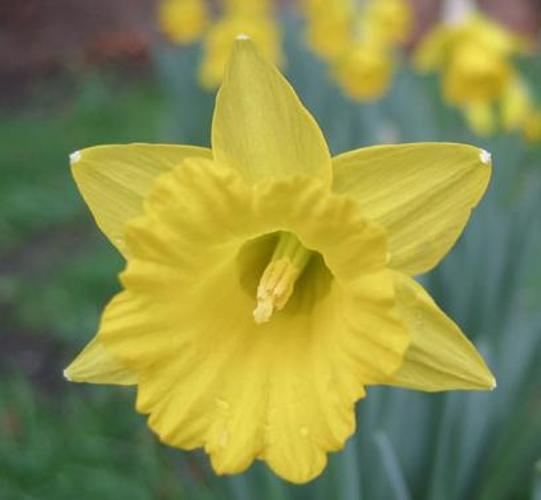

In [ ]:
# view sample image
img = cv2.imread(train['File'][0])
cv2_imshow(img)

# Model Building and Training

In [ ]:
# InceptionV3 model
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',include_top=False, input_shape=(500, 541, 3))

# Load the CONV layers of InceptionV3 model and add custom FC layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(truth), activation='softmax'))

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 541, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 249, 270, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 249, 270, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 249, 270, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
# freeze final convolution layer
for layer in conv_base.layers[:-31]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in conv_base.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc39bc3d710> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc3918bcf90> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc39bc1fad0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fc38f040850> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc38b878890> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc38b881910> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fc38b8788d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc38b892e50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc38b897690> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fc38b88e050> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc38b899e50> False
<tensorflow.python.keras.layers.c

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 14, 15, 2048)      21802784  
_________________________________________________________________
flatten (Flatten)            (None, 430080)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               55050368  
_________________________________________________________________
dense_1 (Dense)              (None, 17)                2193      
Total params: 76,855,345
Trainable params: 61,126,097
Non-trainable params: 15,729,248
_________________________________________________________________


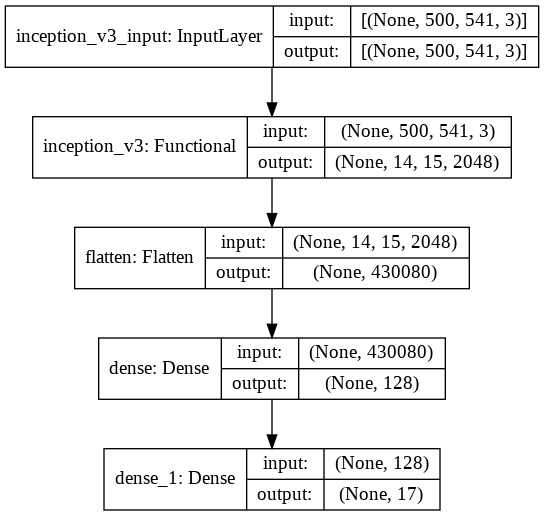

In [ ]:
# view architecture
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=True , rankdir='TB')

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
# make folder to hold weights and model saves
!mkdir '/content/gdrive/MyDrive/Flowers'

mkdir: cannot create directory ‘/content/gdrive/MyDrive/Flowers’: File exists


In [ ]:
# Adding checkpoints after every epochs 
filepath='/content/gdrive/MyDrive/Flowers/weights_InV3.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', save_freq='epoch', save_format="h5")

In [ ]:
# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 0,
                          restore_best_weights = True)

In [ ]:
# epoch tracking: 

In [ ]:
hist = model.fit(
      train_gen,
      steps_per_epoch = train_gen.n // batch_size,  # images = batch_size * steps
      epochs=50,
      validation_data=valid_gen,
      validation_steps = valid_gen.n // batch_size,  # images = batch_size * steps
      callbacks = [checkpoint, es],
      verbose=1)

Epoch 1/50
21/21 [==============================] - 75s 2s/step - loss: 67.8405 - accuracy: 0.1149 - val_loss: 4.2877 - val_accuracy: 0.4250
Epoch 2/50
21/21 [==============================] - 43s 2s/step - loss: 3.8067 - accuracy: 0.3702 - val_loss: 1.8722 - val_accuracy: 0.4594
Epoch 3/50
21/21 [==============================] - 44s 2s/step - loss: 1.6115 - accuracy: 0.4204 - val_loss: 1.9500 - val_accuracy: 0.5500
Epoch 4/50
21/21 [==============================] - 44s 2s/step - loss: 1.1432 - accuracy: 0.6208 - val_loss: 0.9778 - val_accuracy: 0.7500
Epoch 5/50
21/21 [==============================] - 43s 2s/step - loss: 0.8397 - accuracy: 0.7237 - val_loss: 0.8918 - val_accuracy: 0.8031
Epoch 6/50
21/21 [==============================] - 42s 2s/step - loss: 0.5277 - accuracy: 0.8501 - val_loss: 0.5624 - val_accuracy: 0.8781
Epoch 7/50
21/21 [==============================] - 42s 2s/step - loss: 0.4563 - accuracy: 0.8517 - val_loss: 0.7693 - val_accuracy: 0.8188
Epoch 8/50
21/21 [=

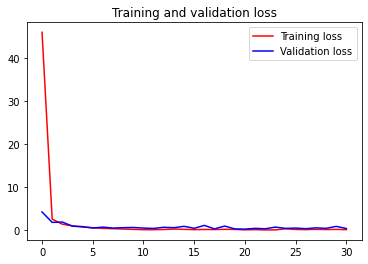

In [ ]:
# Display the train and validation loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_gen)

11/11 [==============================] - 5s 437ms/step - loss: 0.3229 - accuracy: 0.9382


[0.3229030668735504, 0.9382352828979492]

In [ ]:
# Refer to epoch 21 for best training model (num epochs - patience)

## Visualise Images Classified

In [ ]:
# load weights
model.load_weights('/content/gdrive/MyDrive/Flowers/weights_InV3.23-0.39.hdf5')

In [ ]:
# get predictions
preds = np.argmax(model.predict(test_gen), axis=-1)

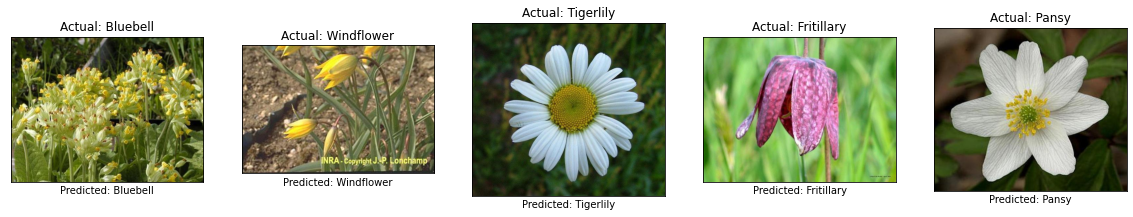

In [ ]:
# randomly select 5 predicted images
import random
n = 5

select = []
for i in range(n):
  while len(select) != n:
    num = random.randint(0, len(preds)-1)
    if num not in select:
      select.append(num)

pred_img = []
for idx, each in enumerate(preds):
  pred_label = truth['FlowerName'][each]
  true_label = truth['FlowerName'][test_gen.labels[idx]]
  pred_img.append([test_gen.filenames[idx], pred_label, true_label])

f, axs = plt.subplots(1,n,figsize=(20,20))
for i in range(n):
  axs[i].xaxis.set_ticks([])
  axs[i].yaxis.set_ticks([])
  axs[i].set_title('Actual: {0}'.format(pred_img[select[i]][2]))
  axs[i].set_xlabel('Predicted: {0}'.format(pred_img[select[i]][1]))
  img = cv2.imread(pred_img[select[i]][0])
  RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axs[i].imshow(RGB_img)
plt.show()

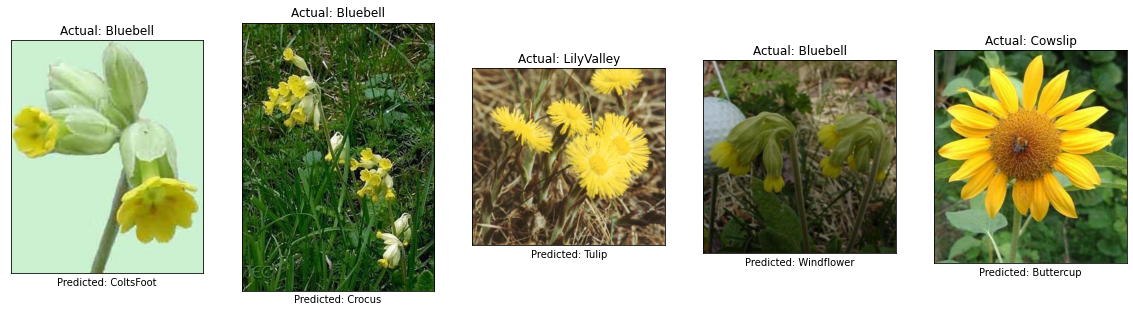

In [ ]:
# randomly select 5 wrongly predicted images
n = 5

pred_img = []
for idx, each in enumerate(preds):
  if each != test_gen.labels[idx]:
    pred_label = truth['FlowerName'][each]
    true_label = truth['FlowerName'][test_gen.labels[idx]]
    pred_img.append([test_gen.filenames[idx], pred_label, true_label])

select = []
for i in range(n):
  while len(select) != n:
    num = random.randint(0, len(pred_img)-1)
    if num not in select:
      select.append(num)

f, axs = plt.subplots(1,n,figsize=(20,20))
for i in range(n):
  axs[i].xaxis.set_ticks([])
  axs[i].yaxis.set_ticks([])
  axs[i].set_title('Actual: {0}'.format(pred_img[select[i]][2]))
  axs[i].set_xlabel('Predicted: {0}'.format(pred_img[select[i]][1]))
  img = cv2.imread(pred_img[select[i]][0])
  RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axs[i].imshow(RGB_img)
plt.show()

# Customised InceptionV3 Model

In [ ]:
from keras.layers import Conv2D, MaxPool2D, concatenate
# Create the InceptionV1 module
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    # 1X1 CONV
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    # 1X1 CONV --> 3x3 CONV
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    # 1X1 CONV --> 5x5 CONV
    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    # 3X3 MAXPOOL --> 1X1 CONV
    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # Concatenate the layers
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [ ]:
# Custom InceptionV3 model

conv_base = InceptionV3(weights='imagenet',include_top=False, input_shape=(500, 541, 3))

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_3x3/2')(conv_base.layers[-1].output)
x = MaxPool2D((3, 3), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)

# add another convolution layer, inceptionV1 module
x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_a')

x = layers.GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = layers.Dropout(0.4)(x)

# fully connected layer
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(len(truth), activation='softmax')(x)

custom_model = models.Model(inputs=conv_base.input, outputs=x)

In [ ]:
# freeze final convolution layer of original architecture
for layer in conv_base.layers[:-31]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in conv_base.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc385433550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc3843c1a50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc383855d10> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fc383855d50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc38ae82590> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc38ae71810> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fc38add4f50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc3838bb950> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc38390fbd0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fc383951590> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc3851d36d0> False
<tensorflow.python.keras.layers.c

In [ ]:
custom_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500, 541, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 249, 270, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 249, 270, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 249, 270, 32) 0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

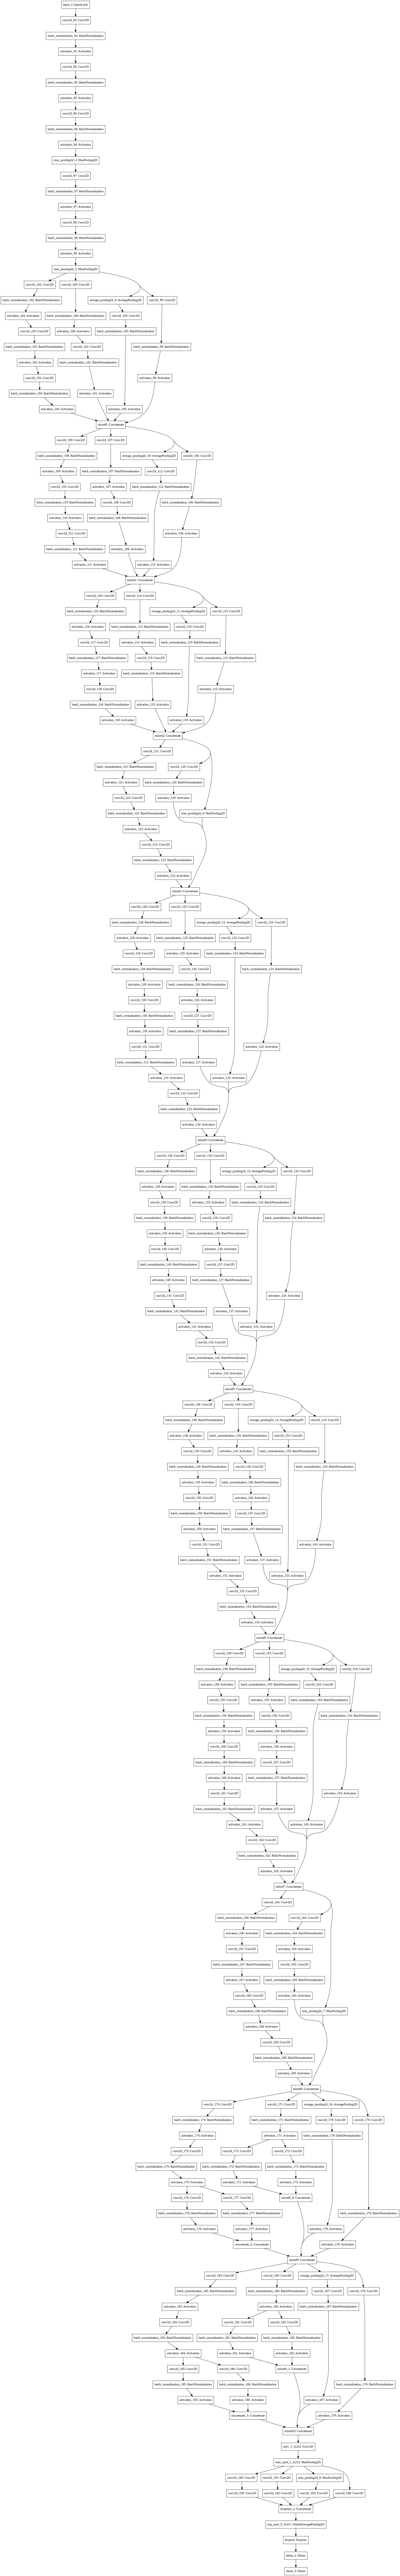

In [ ]:
# view architecture
from keras.utils import plot_model
plot_model(custom_model, to_file='model.png', show_layer_names=True, show_shapes=False , rankdir='TB')

In [ ]:
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
#!rm -r '/content/gdrive/MyDrive/Flowers_custom/'

In [ ]:
# make folder to hold weights and model saves
!mkdir '/content/gdrive/MyDrive/Flowers_custom/'

In [ ]:
# Adding checkpoints after every epochs 
filepath='/content/gdrive/MyDrive/Flowers_custom/weights_InV3.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', save_freq='epoch', save_format="h5")

In [ ]:
# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 0,
                          restore_best_weights = True)

In [ ]:
custom_hist = custom_model.fit(
      train_gen,
      steps_per_epoch = train_gen.n // batch_size,  # images = batch_size * steps
      epochs=100,
      validation_data=valid_gen,
      validation_steps = valid_gen.n // batch_size,  # images = batch_size * steps
      callbacks = [checkpoint, es],
      verbose=1)

Epoch 1/50
21/21 [==============================] - 89s 3s/step - loss: 3.3003 - accuracy: 0.0716 - val_loss: 2.2053 - val_accuracy: 0.2562
Epoch 2/50
21/21 [==============================] - 52s 2s/step - loss: 2.1798 - accuracy: 0.2657 - val_loss: 1.3923 - val_accuracy: 0.5375
Epoch 3/50
21/21 [==============================] - 52s 2s/step - loss: 1.2933 - accuracy: 0.5646 - val_loss: 0.7548 - val_accuracy: 0.7531
Epoch 4/50
21/21 [==============================] - 52s 2s/step - loss: 0.6324 - accuracy: 0.7925 - val_loss: 0.3179 - val_accuracy: 0.9219
Epoch 5/50
21/21 [==============================] - 52s 2s/step - loss: 0.3704 - accuracy: 0.8922 - val_loss: 0.3101 - val_accuracy: 0.9312
Epoch 6/50
21/21 [==============================] - 52s 2s/step - loss: 0.1733 - accuracy: 0.9476 - val_loss: 0.3318 - val_accuracy: 0.9406
Epoch 7/50
21/21 [==============================] - 52s 2s/step - loss: 0.2416 - accuracy: 0.9371 - val_loss: 0.4492 - val_accuracy: 0.9156
Epoch 8/50
21/21 [==

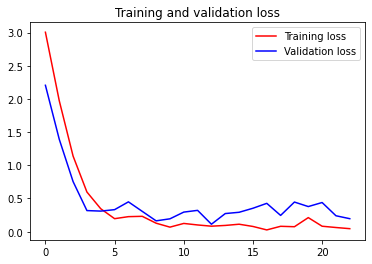

In [ ]:
# Display the train and validation loss
loss = custom_hist.history['loss']
val_loss = custom_hist.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
custom_model.evaluate(test_gen)

11/11 [==============================] - 8s 707ms/step - loss: 0.1474 - accuracy: 0.9676


[0.14742568135261536, 0.9676470756530762]

In [ ]:
# Refer to epoch 13 for best training model (num epochs - patience)

# Visualise Images Classified

In [ ]:
# load weights
custom_model.load_weights('/content/gdrive/MyDrive/Flowers_custom/weights_InV3.23-0.20.hdf5')

In [ ]:
# get predictions
preds = np.argmax(custom_model.predict(test_gen), axis=-1)

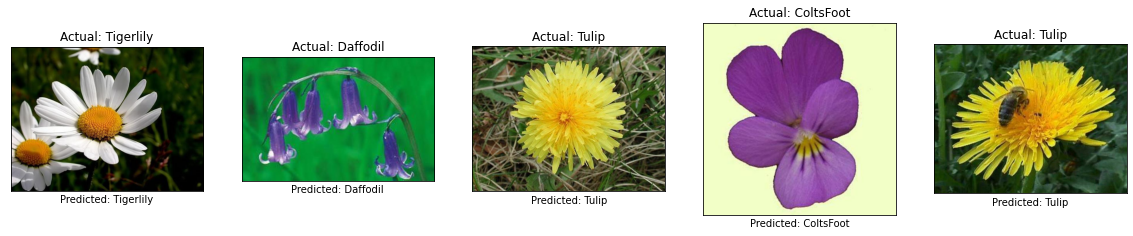

In [ ]:
# randomly select 5 predicted images
import random
n = 5

select = []
for i in range(n):
  while len(select) != n:
    num = random.randint(0, len(preds)-1)
    if num not in select:
      select.append(num)

pred_img = []
for idx, each in enumerate(preds):
  pred_label = truth['FlowerName'][each]
  true_label = truth['FlowerName'][test_gen.labels[idx]]
  pred_img.append([test_gen.filenames[idx], pred_label, true_label])

f, axs = plt.subplots(1,n,figsize=(20,20))
for i in range(n):
  axs[i].xaxis.set_ticks([])
  axs[i].yaxis.set_ticks([])
  axs[i].set_title('Actual: {0}'.format(pred_img[select[i]][2]))
  axs[i].set_xlabel('Predicted: {0}'.format(pred_img[select[i]][1]))
  img = cv2.imread(pred_img[select[i]][0])
  RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axs[i].imshow(RGB_img)
plt.show()

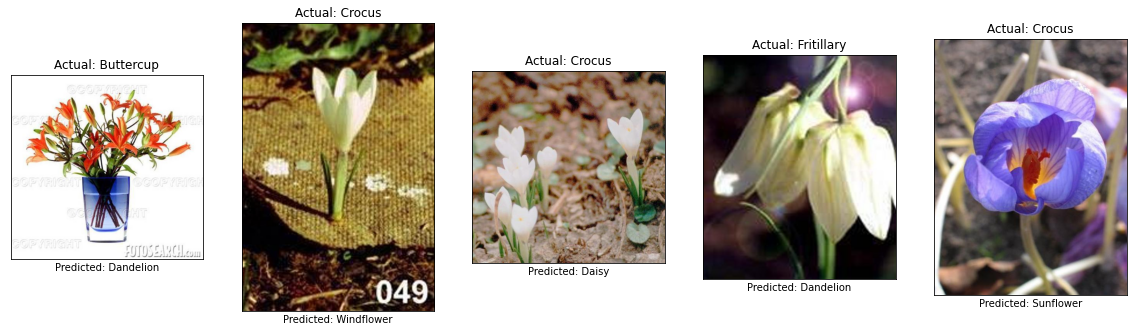

In [ ]:
# randomly select 5 wrongly predicted images
n = 5

pred_img = []
for idx, each in enumerate(preds):
  if each != test_gen.labels[idx]:
    pred_label = truth['FlowerName'][each]
    true_label = truth['FlowerName'][test_gen.labels[idx]]
    pred_img.append([test_gen.filenames[idx], pred_label, true_label])

select = []
for i in range(n):
  while len(select) != n:
    num = random.randint(0, len(pred_img)-1)
    if num not in select:
      select.append(num)

f, axs = plt.subplots(1,n,figsize=(20,20))
for i in range(n):
  axs[i].xaxis.set_ticks([])
  axs[i].yaxis.set_ticks([])
  axs[i].set_title('Actual: {0}'.format(pred_img[select[i]][2]))
  axs[i].set_xlabel('Predicted: {0}'.format(pred_img[select[i]][1]))
  img = cv2.imread(pred_img[select[i]][0])
  RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axs[i].imshow(RGB_img)
plt.show()